In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [2]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Download

In [3]:
ratings = pd.read_csv('data/rating.csv', encoding="latin-1")

In [4]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,155061224,5.0
2,276727,446520802,0.0
3,276729,052165615X,3.0
4,276729,521795028,6.0


In [5]:
ratings.shape

ratings.describe()

(1048575, 3)

,User-ID,Book-Rating
count,1.048575e+06,1.048570e+06
mean,1.285089e+05,2.879905e+00
std,7.421876e+04,3.857869e+00
min,2.000000e+00,0.000000e+00
25%,6.339400e+04,0.000000e+00
50%,1.288350e+05,0.000000e+00
75%,1.927790e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [6]:
books_df = pd.read_csv('data/books.csv', encoding="latin-1")

/Users/sts/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (3,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.



In [7]:
# Drop imageURL features, don't need them 
features = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']
books = books_df[features]

In [8]:
books.shape
books.head(2)

(271379, 5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada


In [9]:
# books.groupby('Book-Title')['Book-Title'].value_counts()

In [10]:
users_df = pd.read_csv('data/users.csv', encoding="latin-1")

/Users/sts/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.



In [11]:
user_features = ['User-ID', 'City', 'State', 'Country', 'Age']
users = users_df[user_features]
users.head()

,User-ID,City,State,Country,Age
0,1.0,nyc,new york,"usa""",NaN
1,2.0,stockton,california,"usa""",18
2,3.0,moscow,yukon territory,"russia""",NaN
3,4.0,porto,v.n.gaia,"portugal""",17
4,5.0,farnborough,hants,"united kingdom""",NaN


In [12]:
users.head()

,User-ID,City,State,Country,Age
0,1.0,nyc,new york,"usa""",NaN
1,2.0,stockton,california,"usa""",18
2,3.0,moscow,yukon territory,"russia""",NaN
3,4.0,porto,v.n.gaia,"portugal""",17
4,5.0,farnborough,hants,"united kingdom""",NaN


# EDA

In [13]:
users.head(2)
users.describe()
# users.info()

,User-ID,City,State,Country,Age
0,1.0,nyc,new york,"usa""",NaN
1,2.0,stockton,california,"usa""",18


,User-ID
count,276270.000000
mean,139452.821023
std,80495.967777
min,1.000000
25%,69746.250000
50%,139458.500000
75%,209164.750000
max,278858.000000


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276271 entries, 0 to 276270
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User-ID  276270 non-null  float64
 1   City     275718 non-null  object 
 2   State    276019 non-null  object 
 3   Country  271708 non-null  object 
 4   Age      165616 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.5+ MB


In [15]:
# replace null value in Age with mean 
users['Age'].isnull().sum() # 110655 null age values 

110655

In [16]:
users.head()

,User-ID,City,State,Country,Age
0,1.0,nyc,new york,"usa""",NaN
1,2.0,stockton,california,"usa""",18
2,3.0,moscow,yukon territory,"russia""",NaN
3,4.0,porto,v.n.gaia,"portugal""",17
4,5.0,farnborough,hants,"united kingdom""",NaN


In [17]:
age_users = users.groupby('Age')['Age'].count()

In [18]:
age_users.shape


(242,)

In [19]:
# Top cities who rated books 
cities = users.groupby('City')['City'].count().sort_values(ascending = False)
cities.head(10)

City
london       4059
barcelona    2642
toronto      2319
madrid       1914
sydney       1868
portland     1847
melbourne    1841
vancouver    1677
chicago      1550
seattle      1521
Name: City, dtype: int64

In [20]:
# Top countriess who rated books 
countries = users.groupby('Country')['Country'].count().sort_values(ascending = False)
countries.head(10)

Country
 usa"               137879
 canada"             21350
 united kingdom"     18130
 germany"            16907
 spain"              13083
 australia"          11591
 italy"              11125
 france"              3447
 portugal"            3342
 new zealand"         3059
Name: Country, dtype: int64

In [22]:
# Replace Age value = '&#22269' with nan 
# users.Age.replace('&#22269', 0, inplace = True)
# users.loc[((users.Age > 95) | (users.Age < 4)), 'Age'] = np.nan

In [23]:
# Remove " form age:  7"  = 7 

# users['Age'] = users['Age'].str.replace(r"[\"\',]", '')

In [24]:
# replace nan with 0
users.Age.replace(np.nan, 0, inplace = True)

In [26]:
# users['Age'] = users['Age'].astype(int)

# Rating EDA 
## Unique Users: 95513
## Unique ISBN of Books = 322472

In [27]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,155061224,5.0
2,276727,446520802,0.0
3,276729,052165615X,3.0
4,276729,521795028,6.0


In [28]:
ratings['User-ID'].nunique() # 95513
ratings['ISBN'].nunique() # 322472

95513

322472

# Long Tail distribuiton (of rating)


<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Book Rating')

Text(0.5, 0, 'Ratings')

Text(0, 0.5, 'Number of ratings')

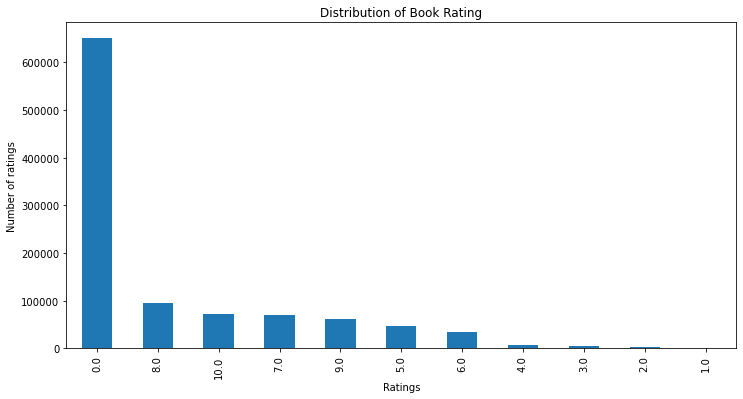

In [29]:
# Long Tail distribuiton 
ratings['Book-Rating'].value_counts().plot(kind='bar', figsize = (12,6))
plt.title('Distribution of Book Rating')
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
plt.savefig('png/book_rating.png', bbox_inches='tight')
plt.show()

In [30]:
ratings['Book-Rating'].value_counts()# [8:].sum()
ratings.shape

0.0     651327
8.0      95037
10.0     71813
7.0      70018
9.0      62101
5.0      46953
6.0      33752
4.0       8031
3.0       5445
2.0       2492
1.0       1601
Name: Book-Rating, dtype: int64

(1048575, 3)

# Explecit rating 

<AxesSubplot:xlabel='Book-Rating', ylabel='count'>

Text(0.5, 1.0, 'Explicit Ratings')

Text(0.5, 0, 'Ratings')

Text(0, 0.5, 'Counts')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0'),
  Text(6, 0, '7.0'),
  Text(7, 0, '8.0'),
  Text(8, 0, '9.0'),
  Text(9, 0, '10.0')])

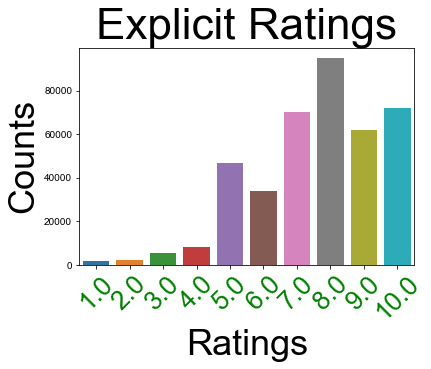

In [31]:
# Rating without 0 
explicit_rate = ratings[ratings['Book-Rating'] != 0]
sns.countplot(data = explicit_rate, x = 'Book-Rating')
sns.set(rc={'figure.figsize':(16,8)})

plt.title('Explicit Ratings', fontsize = 44)
plt.xlabel('Ratings', fontsize=36)
plt.ylabel('Counts', fontsize=36)
plt.xticks(fontsize = 26, rotation = 45, color='green')

plt.savefig('png/explicit_book_rating.png', bbox_inches='tight')

plt.show()


# Books EDA 

In [32]:
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada


In [33]:
# .describe > unique gives the same information 
books.ISBN.nunique()
books['Book-Title'].nunique()
books['Book-Author'].nunique()
books['Year-Of-Publication'].nunique()
books['Publisher'].nunique()

271379

238492

92867

204

15363

In [34]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          233754 non-null  object
 3   Year-Of-Publication  232410 non-null  object
 4   Publisher            232408 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [35]:
# books['Year-Of-Publication'].unique()
books['Year-Of-Publication'].value_counts()
books['Year-Of-Publication'].count()


2002                12819
1999                12496
2001                12399
2000                12340
1998                11179
                    ...  
K.C. Constantine        1
1378                    1
1902                    1
Bart Rulon              1
2008                    1
Name: Year-Of-Publication, Length: 204, dtype: int64

232410

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Book publication by year ')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of books')

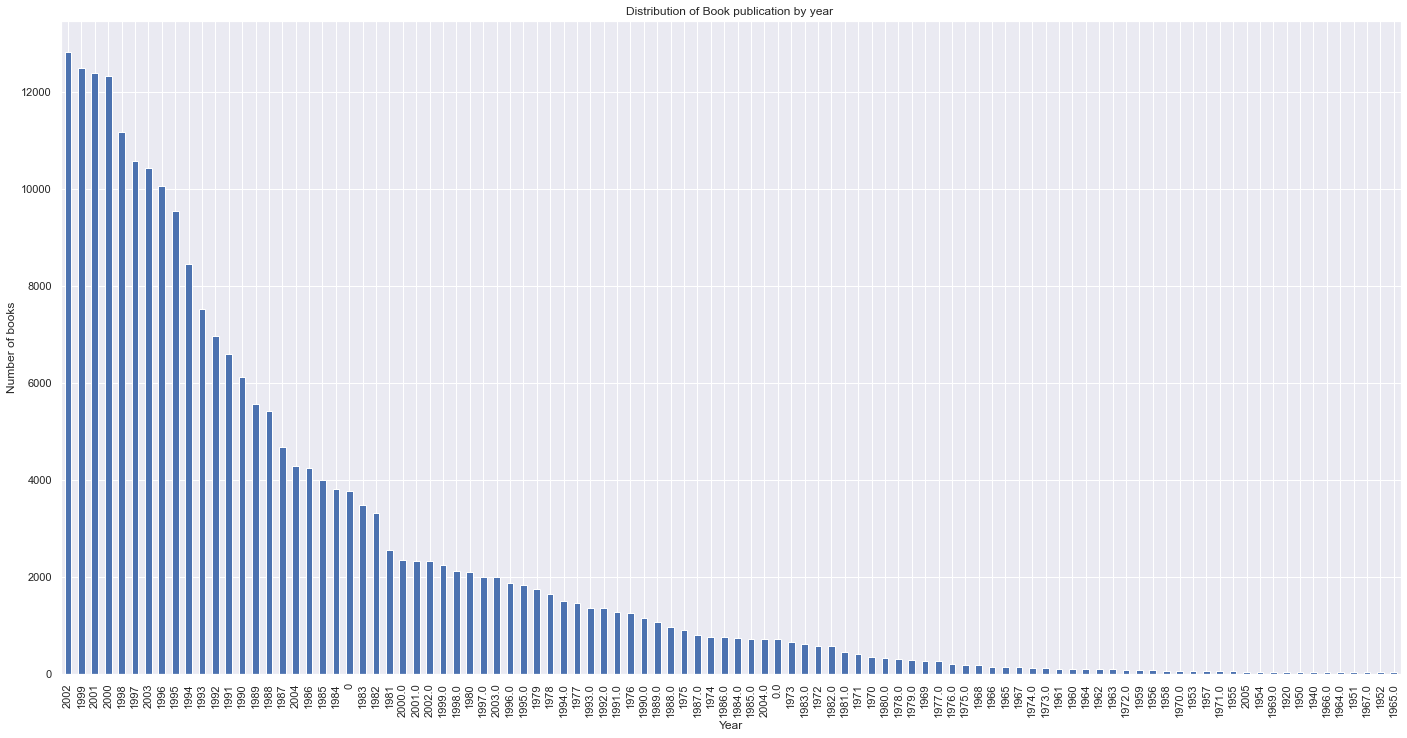

In [36]:
# Books by each year 
books['Year-Of-Publication'].value_counts().head(100).plot(kind='bar', figsize=(24,12))
plt.title('Distribution of Book publication by year ')
plt.xlabel('Year')
plt.ylabel('Number of books')
plt.savefig('book_published_year.png', bbox_inches='tight')
plt.show()

# Popularity Based filtering: Top rated books

In [37]:
users.head(2)

,User-ID,City,State,Country,Age
0,1.0,nyc,new york,"usa""",0
1,2.0,stockton,california,"usa""",18


In [38]:
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,155061224,5.0


In [39]:
user_rating = pd.merge(users, ratings, on='User-ID', how='inner')
# user_rating.drop(['State'], axis=1, inplace=True)
user_rating.drop(['Age'], axis=1, inplace=True)

In [40]:
user_rating

,User-ID,City,State,Country,ISBN,Book-Rating
0,2.0,stockton,california,"usa""",195153448,0.0
1,7.0,washington,dc,"usa""",34542252,0.0
2,8.0,timmins,ontario,"canada""",2005018,5.0
3,8.0,timmins,ontario,"canada""",60973129,0.0
4,8.0,timmins,ontario,"canada""",374157065,0.0
...,...,...,...,...,...,...
1038047,278854.0,portland,oregon,"usa""",425163393,7.0
1038048,278854.0,portland,oregon,"usa""",515087122,0.0
1038049,278854.0,portland,oregon,"usa""",553275739,6.0
1038050,278854.0,portland,oregon,"usa""",553578596,0.0


In [41]:
# Top users who rated most books 
user_rating.groupby('User-ID').count().sort_values('Book-Rating', ascending=False)

,City,State,Country,ISBN,Book-Rating
User-ID,,,,,
11676.0,0,13602,13602,13602,13602
198711.0,7550,7550,7550,7550,7550
153662.0,6109,6109,6109,6109,6109
98391.0,5891,5891,5891,5891,5891
35859.0,5850,5850,5850,5850,5850
...,...,...,...,...,...
107698.0,1,1,1,1,1
107700.0,1,1,1,1,1
126363.0,1,1,1,1,1


# Top users to rate most books
* Possible users for testing market, since they tend to give response: react/rate books 

In [42]:
# top 10 users for ratings 

user_rate_count = pd.DataFrame(user_rating.groupby('User-ID').count())

user_rate_count.sort_values(by = ['Book-Rating'], ascending=False).head(10)


,City,State,Country,ISBN,Book-Rating
User-ID,,,,,
11676.0,0,13602,13602,13602,13602
198711.0,7550,7550,7550,7550,7550
153662.0,6109,6109,6109,6109,6109
98391.0,5891,5891,5891,5891,5891
35859.0,5850,5850,5850,5850,5850
212898.0,4785,4785,4785,4785,4785
278418.0,4533,4533,4533,4533,4533
76352.0,3367,3367,3367,3367,3367
110973.0,3100,3100,3100,3100,3100


In [43]:
count_of_rating = pd.DataFrame(explicit_rate.groupby('ISBN')['Book-Rating'].count())
top_rated = count_of_rating.sort_values('Book-Rating', ascending=False)
top_rated.head(10)

,Book-Rating
ISBN,
316666343,635
971880107,526
385504209,452
312195516,354
679781587,302
60928336,292
059035342X,285
142001740,283
446672211,265


# Pobularity based recommender 
## Top explicitly rated books 

In [44]:
# Top 10 most rated books 
top_rated_books = pd.merge(top_rated, books, on='ISBN')
top_rated_books.head(10)

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,316666343,635,The Lovely Bones: A Novel,Alice Sebold,2002,Little
1,971880107,526,Wild Animus,Rich Shapero,2004,Too Far
2,385504209,452,The Da Vinci Code,Dan Brown,2003,Doubleday
3,312195516,354,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,60928336,292,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
5,059035342X,285,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
6,142001740,283,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
7,446672211,265,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
8,044023722X,259,A Painted House,John Grisham,2001,Dell Publishing Company
9,452282152,257,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books


# Average Rating of books 

In [45]:
avg_rating = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].mean())
avg_rating['Count_rating'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
most_rated = avg_rating.sort_values('Count_rating', ascending=False)
top_10 = most_rated.head(10)
top_10

,Book-Rating,Count_rating
ISBN,,
971880107,1.032244,2264
316666343,4.457045,1164
385504209,4.691267,813
312195516,4.326347,668
60928336,3.462236,662
044023722X,3.166387,595
679781587,4.378893,578
142001740,4.331532,555
067976402X,3.278986,552


In [46]:
avg_rated_books = pd.merge(top_10, books, on='ISBN')
avg_rated_books.head(10)

,ISBN,Book-Rating,Count_rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,971880107,1.032244,2264,Wild Animus,Rich Shapero,2004,Too Far
1,316666343,4.457045,1164,The Lovely Bones: A Novel,Alice Sebold,2002,Little
2,385504209,4.691267,813,The Da Vinci Code,Dan Brown,2003,Doubleday
3,312195516,4.326347,668,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,60928336,3.462236,662,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
5,044023722X,3.166387,595,A Painted House,John Grisham,2001,Dell Publishing Company
6,142001740,4.331532,555,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
7,067976402X,3.278986,552,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA
8,671027360,3.811567,536,Angels &amp; Demons,Dan Brown,2001,Pocket Star


# Collaborative Filtering 
* User-based recommender 
* Using Matrix Factorization



In [47]:
rating_book_combo = pd.merge(ratings, books, on='ISBN')
rating_book_combo.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


In [48]:
rating_book_combo.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher'],
      dtype='object')

In [49]:
# Create table for colaborative filtering with user-ID, ISBN, rating, title 
colab_feature = ['User-ID', 'ISBN', 'Book-Rating', 'Book-Title']
colab_df = rating_book_combo[colab_feature]

In [50]:
colab_df.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0.0,Flesh Tones: A Novel
1,2313,034545104X,5.0,Flesh Tones: A Novel
2,6543,034545104X,0.0,Flesh Tones: A Novel
3,8680,034545104X,5.0,Flesh Tones: A Novel
4,10314,034545104X,9.0,Flesh Tones: A Novel


In [51]:
# Count number of ratings given to each book by different users 
number_of_ratings = (colab_df.
     groupby(by = ['Book-Title'])['Book-Rating'].
     count().
     reset_index().
     rename(columns = {'Book-Rating': 'Number_of_Ratings'})
     [['Book-Title', 'Number_of_Ratings']])

number_of_ratings.sort_values(by = 'Number_of_Ratings', \
                ascending = False).head(2)

,Book-Title,Number_of_Ratings
221093,Wild Animus,2264
184426,The Lovely Bones: A Novel,1164


In [52]:
# join table with count of rating 
rating_with_count = colab_df.\
    merge(number_of_ratings, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
rating_with_count.head()

,User-ID,ISBN,Book-Rating,Book-Title,Number_of_Ratings
0,276725,034545104X,0.0,Flesh Tones: A Novel,53
1,2313,034545104X,5.0,Flesh Tones: A Novel,53
2,6543,034545104X,0.0,Flesh Tones: A Novel,53
3,8680,034545104X,5.0,Flesh Tones: A Novel,53
4,10314,034545104X,9.0,Flesh Tones: A Novel,53


In [53]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(number_of_ratings['Number_of_Ratings'].describe())

count   226808.00
mean         4.15
std         15.77
min          1.00
25%          1.00
50%          1.00
75%          3.00
max       2264.00
Name: Number_of_Ratings, dtype: float64


In [54]:
# create a threshhold of ratings to include 
rating_threshold = 100
most_rated_books= rating_with_count.\
    query('Number_of_Ratings >= @rating_threshold')
most_rated_books.shape
most_rated_books.nunique()
most_rated_books.tail()

(160101, 5)

User-ID              33860
ISBN                  3064
Book-Rating             11
Book-Title             826
Number_of_Ratings      265
dtype: int64

,User-ID,ISBN,Book-Rating,Book-Title,Number_of_Ratings
939096,247958,786004304,0.00,Over the Edge,107
939250,248280,553204742,9.00,Where the Red Fern Grows,125
939464,248718,031202164X,8.00,Ashes to Ashes,201
939653,248718,080501196X,10.00,Oh,151
940861,250405,399144781,0.00,Southern Cross,209


## User based recommender 
* User-user hypothesis: Similar users tend to give similar ratings to a single product

* Make table with Book title as index and user ID on Columns with ratings


In [55]:
# Create a pivot table 
# ratings based on book similarity 
# create sparse matrix 

book_ratings_table = pd.pivot_table(most_rated_books, \
                    index = 'Book-Title', columns = 'User-ID', \
                            values = 'Book-Rating').fillna(0)


In [56]:
book_ratings_table.head()

User-ID,8,9,14,16,17,26,32,39,42,44,...,278819,278820,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1st to Die: A Novel,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2nd Chance,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4 Blondes,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
84 Charing Cross Road,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [57]:
from scipy.sparse import csr_matrix

book_ratings_table_mtx = csr_matrix(book_ratings_table.values)

In [58]:
book_ratings_table_mtx.shape

(826, 33860)

In [59]:
from sklearn.neighbors import NearestNeighbors


knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn.fit(book_ratings_table_mtx)

NearestNeighbors(algorithm='brute', metric='cosine')

In [60]:
book_ratings_table.shape
# book_ratings_table.head()

(826, 33860)

In [61]:
book_ratings_table.index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       '84 Charing Cross Road',
       'A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower', 'Women Who Run with the Wolves',
       'Wuthering Heights', 'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=826)

In [62]:
# Find books based on similarity 

index_ask = np.random.choice(book_ratings_table.shape[0])
# index_ask = 1
print(index_ask)



# how many similar books 
number_of_similar_books = 6

dis_similarity, indexs = knn.kneighbors(book_ratings_table.\
                    iloc[index_ask,:].values.reshape(1, -1),\
                            n_neighbors = number_of_similar_books)

# dis_similarity
# indexs

for i in range(0, len(dis_similarity.flatten())):
    if i == 0:
        print('\n If you like the Book: \n\n****\n {0} \n****\n\n You will like following books: \n'.\
              format(book_ratings_table.index[index_ask]))
    else:
        print('{0}: {1}, \n\t\t with similarity of {2}:'.format(i, book_ratings_table.\
                    index[indexs.flatten()[i]], 1 - dis_similarity.flatten()[i]))
        
        
        

431

 If you like the Book: 

****
 Possession : A Romance 
****

 You will like following books: 

1: Charlotte's Web (Trophy Newbery), 
		 with similarity of 0.10628017244765342:
2: The Reptile Room (A Series of Unfortunate Events, 
		 with similarity of 0.08965999968890537:
3: 84 Charing Cross Road, 
		 with similarity of 0.08378349483444225:
4: Moo, 
		 with similarity of 0.07770544185679518:
5: Shopgirl, 
		 with similarity of 0.07623849311719455:
